In [8]:
from imutils import face_utils
import numpy as np
import imutils
import dlib
import cv2
import json
import matplotlib.pyplot as plt
import math
import seaborn as sns

In [9]:
# load file
FILE_NAME = "00485_Chinese_Asian_Female_Young/00485_1"
# define video path
VIDEOPATH = "../video/" + FILE_NAME + ".mp4"
# define json path
JSONPATH = "../video/" + FILE_NAME + ".json"
# use 68 key points face model
SHAPE_PREDICTOR = "model/shape_predictor_68_face_landmarks.dat"
# define lip region
(LIPFROM, LIPTO) = (49, 68)
# define threshold for lip motion
HIGH_THRESHOLD = 0.65
LOW_THRESHOLD = 0.4

In [10]:
# load json info
with open(JSONPATH,'r', encoding='utf-8') as load_f:
    load_dict = json.load(load_f)
# record speaking period
duration = []
for recored in load_dict:
    start = recored['start time']
    end = recored['end time']
    duration.append((start, end))
# print(duration)
# exit()

In [11]:
# define the face detector
DETECTOR = dlib.get_frontal_face_detector()
# define a shape predictor
PREDICTOR = dlib.shape_predictor(SHAPE_PREDICTOR)

In [12]:
# read original video
# fvs = FileVideoStream(path=VIDEOPATH).start()
VC = cv2.VideoCapture(VIDEOPATH)
FRAME_RATE = VC.get(cv2.CAP_PROP_FPS)
print(FRAME_RATE)
# define output video
FRAME_WIDTH = int(VC.get(cv2.CAP_PROP_FRAME_WIDTH))
FRAME_HEIGHT = int(VC.get(cv2.CAP_PROP_FRAME_HEIGHT))
# out = cv2.VideoWriter('video/out_dlib.avi', cv2.VideoWriter_fourcc('M','J','P','G'), 30, (frame_width,frame_height))

24.666666666666668


In [13]:
def lip_aspect_ratio(lip):

    # left top to left bottom
    A = np.linalg.norm(lip[2] - lip[9])  # 51, 59
    # right top to right bottom
    B = np.linalg.norm(lip[4] - lip[7])  # 53, 57
    # leftest to rightest
    C = np.linalg.norm(lip[0] - lip[6])  # 49, 55
    lar = (A + B) / (2.0 * C)

    return lar

In [20]:
def process_frame(frame):

    # preprocess
    frame = imutils.resize(frame, width=640)
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # detect face rect
    rects = DETECTOR(frame_gray, 0)

    Lars = []

    for rect in rects:
        # find key points inside the face rect
        shape = PREDICTOR(frame_gray, rect)
        shape = face_utils.shape_to_np(shape)

        # locate lip region
        lip = shape[LIPFROM:LIPTO]
        print(shape.shape())
        print('shape', shape)
        # get lip aspect ratio
        lar = lip_aspect_ratio(lip)
        Lars.append(lar)

        # get the shape of lip
        lip_shape = cv2.convexHull(lip)
        cv2.drawContours(frame, [lip_shape], -1, (0, 255, 0), 1)
        cv2.putText(frame, "LAR: {:.2f}".format(lar), (30, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 1)

        # if open
        if lar > HIGH_THRESHOLD or lar < LOW_THRESHOLD:
            cv2.putText(frame, "Mouth is Open!", (30, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 1)                

    return Lars, frame

In [21]:
def get_mode(nums):
    counts = np.bincount(nums)
    mode = np.argmax(counts)
    return mode

In [22]:
LARs = []
while (VC.isOpened()):
    # read frames
    rval, frame = VC.read()
    if rval:
        lar, frame = process_frame(frame)
        LARs = LARs + lar
    else: 
        break

plt.figure(figsize=(100,10))
x = np.arange(len(LARs))
plt.plot(x, LARs,'-')
plt.show()

TypeError: 'tuple' object is not callable

In [69]:
print('Min:', min(LARs))
print('Max:', max(LARs))
print('Avg:', np.mean(LARs))
print('Std:', np.std(LARs))

Min: 0.3823666184276258
Max: 0.9002474066078935
Avg: 0.6364279352212924
Std: 0.0619987748788807


In [70]:
if VC.isOpened:
	FrameNumber = VC.get(7)
	VIDEO_LENGTH = FrameNumber/FRAME_RATE
print(VIDEO_LENGTH)

304.86486486486484


In [71]:
GROUNG_TRUTH = []
for i in range(math.ceil(VIDEO_LENGTH)):
    GROUNG_TRUTH.append(False)

In [72]:
for (start, end) in duration:
    s = round(start)
    e = round(end)
    for i in range(s, e):
        GROUNG_TRUTH[i] = True

In [99]:
PREDICTION = []
idx = 0
while idx < len(LARs):
    if idx % 48 == 0 or idx % 49 == 0 or idx % 100 == 0:
        idx += 1
        continue
    temp = []
    for i in range(math.floor(FRAME_RATE)):
        lar = LARs[idx]
        if lar > 0.65 or lar < 0.48:
        # if lar > 0.65:
            temp.append(1)
        else:
            temp.append(0)
        idx += 1
        if idx == len(LARs):
            break
    pred = get_mode(temp)
    if(pred):
        PREDICTION.append(True)
    else:
        PREDICTION.append(False)

In [100]:
TN = 0
TP = 0
FN = 0
FP = 0
for i in range(len(GROUNG_TRUTH)):
    if GROUNG_TRUTH[i]:
        if PREDICTION[i]:
            TN += 1
        else:
            FP += 1
    else:
        if PREDICTION[i]:
            FN += 1
        else:
            TP += 1
alpha = FP/(FP+TN)
beta = FN/(FN+TP)
correct_rate = (TN+TP)/(FP+TN+FN+TP)

alpha: 0.35374149659863946
beta: 0.22784810126582278
correct_rate: 0.7114754098360656


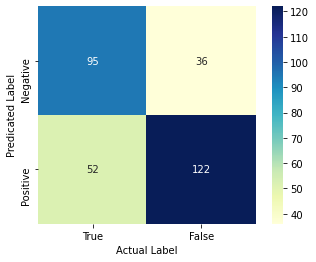

In [101]:
mat = np.mat([[TN, FN], [FP, TP]])
# mat = confusion_matrix(dftest.iloc[:,-1], prediction_test)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=True, cmap="YlGnBu",
            xticklabels=['True','False'],
            yticklabels=['Negative','Positive'])    
plt.xlabel('Actual Label')
plt.ylabel('Predicated Label')
print('alpha:', alpha)
print('beta:', beta)
print('correct_rate:', correct_rate)

In [76]:
sum_motion_lar = []
for (start, end) in duration:
    t = int(start - 1) * 1000
    Lars = []
    while t < int(end + 1)  * 1000:
        VC.set(cv2.CAP_PROP_POS_MSEC, t)
        rval, frame = VC.read()
        if rval:
            lar, frame = process_frame(frame)
            # plt.imshow(frame)
        else:
            lar = [0]
        Lars = Lars + lar
        t += 100
    sum_motion_lar = sum_motion_lar + Lars
    
    # print(start, '-', end, ':')
    # print('Min:', min(Lars))
    # print('Max:', max(Lars))
    # print('Avg:', np.mean(Lars))
    # print('Std:', np.std(Lars))
    # x = np.arange(int(start - 1), int(end + 1), 0.1)
    # plt.plot(x, Lars,'o-')
    # plt.xlabel('time')
    # plt.ylabel('lar')
    # plt.show()

print('Min:', min(sum_motion_lar))
print('Max:', max(sum_motion_lar))
print('Avg:', np.mean(sum_motion_lar))
print('Std:', np.std(sum_motion_lar))

Min: 0.3823666184276258
Max: 0.8893854202903689
Avg: 0.6620148667757851
Std: 0.05469730692278259
